# GPT1 모델 구현해보기

improving language understanding by generative pre-training라는 논문을 읽기


## 1. Transformer와 비교하여 GPT에서 변경이 필요한 부분 서술하기

- Transformer는 인코더와 디코더로 이루어져 있다. GPT는 Transformer의 decoder만을 사용한다.
- 그러므로, gpt1 모델을 구축할 때에는 Transformer의 decoder 속에 있는 masked multi-head attention, layer normalization, feed forward를 이용하여 구현하면 된다. 

- 논문 3-3에서 제시된 것처럼, task에 맞게 input 데이터를 변환시켜주어야 한다.


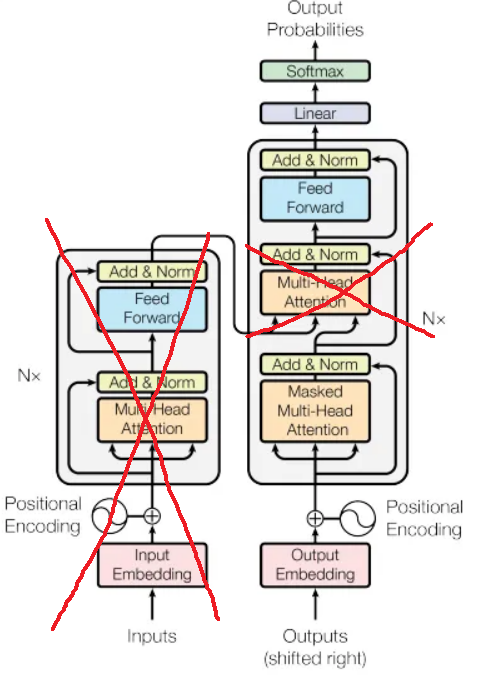

## 2. 모델의 입력 형태에 맞게 전처리를 수행하기
- 우리 프로젝트는 대화형 챗봇을 구현하는 것이므로, QA모델에 맞는 input 형태로 변환하는 것이 적절하다.
- 그러므로, 논문에 제시된 내용을 참고할 때 적절할 input의 형태는 다음과 같다.
    - startoken + context + $(delimiter) + answer + endtoken

In [140]:
# 모델 불러오기
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [141]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",", "$")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r'[^a-zA-Z.,?!$]', ' ', sentence)
  sentence = sentence.strip()
  return sentence

In [142]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

  # input과 output을 delimiter인 $를 사이로 연결해준다. 
      if len(inputs) >= MAX_SAMPLES:
        sequence = []
        for i in range(len(inputs)):
          sequence.append(inputs[i] + ' $ ' + outputs[i])
        return sequence
  
  sequence = []
  for i in range(len(inputs)):
    sequence.append(inputs[i] + ' $ ' + outputs[i])
  
  return sequence
print("슝=3")

슝=3


In [143]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
input_seq = load_conversations()
print('전체 샘플 수 :', len(input_seq))

전체 샘플 수 : 50000


In [144]:
# 질문 $ 답변 순서로 이루어진 것을 확인할 수 있다.

print("전처리 후의 질문 샘플들")
for i in range(5):
    print(input_seq[i] + "\n")

전처리 후의 질문 샘플들
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break  up on the quad . again . $ well , i thought we d start with pronunciation , if that s okay with you .

well , i thought we d start with pronunciation , if that s okay with you . $ not the hacking and gagging and spitting part . please .

not the hacking and gagging and spitting part . please . $ okay . . . then how  bout we try out some french cuisine . saturday ? night ?

you re asking me out . that s so cute . what s your name again ? $ forget it .

no , no , it s my fault    we didn t have a proper introduction $ cameron .



In [145]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(input_seq, target_vocab_size=2**13)

In [146]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [147]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8061]
END_TOKEN의 번호 : [8062]


In [148]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8063


In [149]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# inputs와 outputs의 두 텍스트 길이를 각각 40이라고 가정하면,
# decoder에 들어갈 총 문장은 80이라고 단순하게 생각할 수 있다.

MAX_LENGTH = 80
print(MAX_LENGTH)

80


In [150]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(input_sequences):
  tokenized_inputs = []
  
  for sentence in input_sequences:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence) <= MAX_LENGTH:
      tokenized_inputs.append(sentence)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs
print("슝=3")

슝=3


In [151]:
tokenized_seq = tokenize_and_filter(input_seq)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 input 샘플 개수: {}'.format(len(input_seq)))

단어장의 크기 : 8063
필터링 후의 input 샘플 개수: 50000


In [152]:
print(tokenized_seq[1])

[8061   73    2    3  188   20   58  372   41 1065 1753 3775  844    2
   54   16    8 1331   41   28    7   38    5 4620   96   14 3801 3931
   14 2947 1244 1922    1  266    6 8062    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


## 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하기

In [153]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [154]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [155]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 자연수로 딱 맞게 떨어져야 한다.

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # (batch_size, seq_len, d_model)
    key = self.key_dense(key)        # (batch_size, seq_len, d_model)
    value = self.value_dense(value)  # (batch_size, seq_len, d_model)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    key = self.split_heads(key, batch_size)      # (batch_size, num_heads, seq_len_k, depth)
    value = self.split_heads(value, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [156]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [157]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [158]:
# GPT의 디코더 블록을 정의한다.
def gpt_decoder_layer(units, d_model, num_heads, dropout, name="gpt_decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 멀티 헤드 어텐션 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="self_attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention) 
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention) # Layer normalization
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)

## 4. GPT 모델을 정상적으로 구성하기

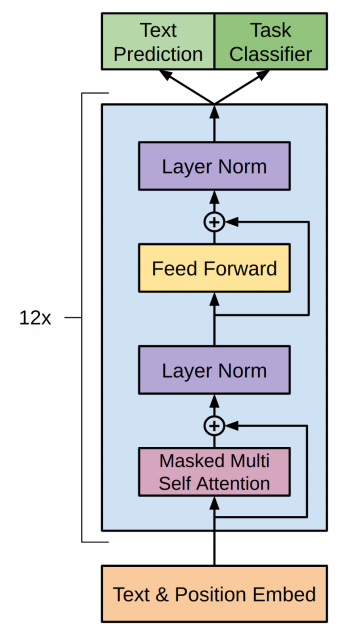

In [159]:
def gpt_model(vocab_size,
              num_layers, # 논문에서는 12개의 레이어를 사용한다.
              units,
              d_model,
              num_heads,
              dropout,
              name="gpt_model"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # GPT 디코더 블록 반복 적용
    for i in range(num_layers):
        outputs = gpt_decoder_layer(units, d_model, num_heads, dropout, name=f"gpt_decoder_layer_{i}")(
            [outputs, look_ahead_mask]
        )
    # 최종 레이어 정규화
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-5)(outputs)
    
    # 출력층 (언어 모델링을 위한 Softmax)
    logits = tf.keras.layers.Dense(vocab_size, name="logits")(outputs)
    
    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=logits, name=name)

print("GPT 모델 정의됨.")



GPT 모델 정의됨.


In [160]:
d_model = 256
units = 512
num_heads = 8
num_layers = 4
dropout = 0.1

# 모델 초기화
model = gpt_model(VOCAB_SIZE, num_layers, units, d_model, num_heads, dropout)

model.summary()

Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 256)    2064128     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_11 (TFOpLambda (None, None, 256)    0           embedding_11[0][0]               
__________________________________________________________________________________________________
positional_encoding_11 (Positio (None, None, 256)    0           tf.math.multiply_11[0][0]        
__________________________________________________________________________________________

## 5. 입력에 따른 출력을 생성하기